# Anomaly Detection of Retail Store Sales

This hands-on mini-project will enable you to reinforce your learnings pertaining to anomaly detection in this unit. By now, you must already be aware of the key objective of anomaly detection. Just to refresh your memory, anomaly detection is the identification of outliers or rare event items in a dataset which potentially exhibit abnormal behavior or properties as compared to the rest of the datapoints.

There are a wide variety of anomaly detection methods including supervised, unsupervised and semi-supervised. Typically you can perform anomaly detection on univariate data, multivariate data as well as data which is temporal in nature. In this mini-project you will leverage state-of-the-art anomaly detection models from frameworks like [__`scikit-learn`__](https://scikit-learn.org/stable/modules/outlier_detection.html) and [__`PyOD`__](https://pyod.readthedocs.io/en/latest/index.html).


By the end of this mini-project, you will have successfully applied these techniques to find out potential outliers pertaining to sales transactional data in a retail store dataset and also learnt how to visualize outliers similar to the following plot.

![](outlier_ex.png)

We will be performing anomaly detection on both univariate and multivariate data and leverage the following anomaly detection techniques.

- Simple Statistical Models (mean & standard deviation: the three-sigma rule)
- Isolation Forest
- Clustering-Based Local Outlier Factor
- Auto-encoders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Getting and Loading the Dataset

The first step towards solving any data science or machine learning problem is to obtain the necessary data. In this scenario, we will be dealing with a popular retail dataset known as the [SuperStore Sales Dataset](https://community.tableau.com/docs/DOC-1236) which consists of transactional data pertaining to a retail store.

#### Please download the required dataset from [here](https://community.tableau.com/docs/DOC-1236) if necessary, although it will also be provided to you along with this notebook for this mini-project

Once we have the necessary data, we will load up the dataset and perform some initial exploratory data analysis

# 2. Exploratory Data Analysis

It's time to do some basic exploratory analysis on the retail store transactional data. We start by loading up the dataset into a pandas dataframe.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


df = pd.read_excel("/content/drive/MyDrive/UCSD_MLE/Projects/mec-16.4.1-anomaly-detection-mini-project/Superstore.xls")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

We don't have any major missing values in our dataset and we can now look at a sample subset of the data

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Visualize Sales vs. Order Date 

Let's look more closely at the __`Sales`__ attribute of the dataset in the next few cells. We'll start by looking at typical sales over time 

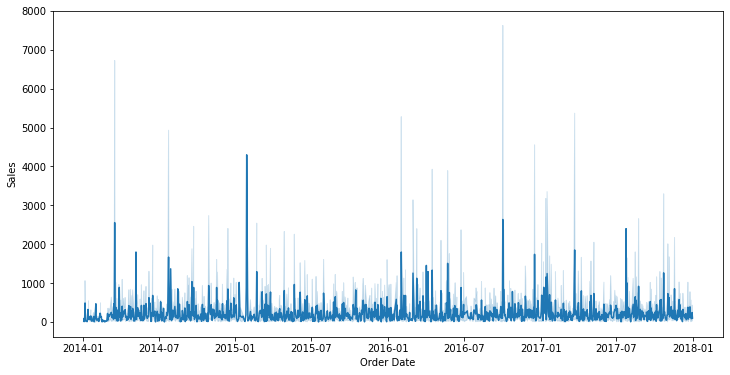

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x=df['Order Date'], y=df['Sales']);

## Visualize Sales Distribution


Let's now look at the data distribution for __`Sales`__

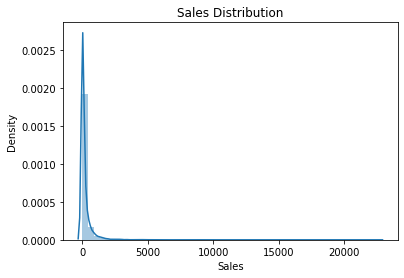

In [6]:
sns.distplot(df['Sales'])
plt.title("Sales Distribution");

In [7]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

We can definitely see the presence of potential outliers in terms of the min or max values as compared to the meat of the distribution in the interquartile range as observed in the distribution statistics

## Q 2.1: Visualize Profit vs. Order Date 

Let's now look closely at the __`Profit`__ attribute of the dataset in the next few cells. We'll start by looking at typical profits over time.

__Your turn: Plot `Order Date` vs. `Profit` using a line plot__

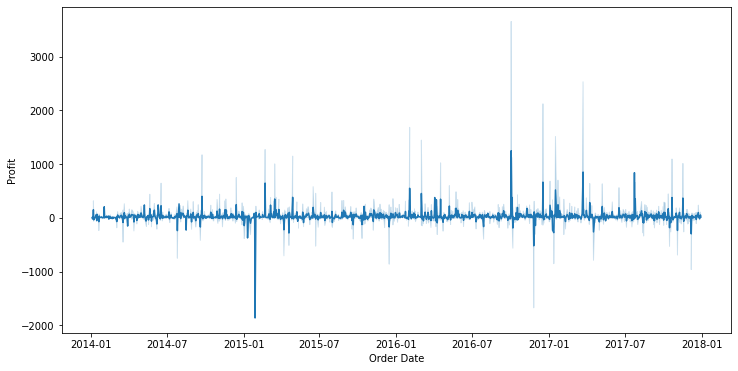

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x=df['Order Date'], y=df['Profit']);

## Q 2.2: Visualize Profit Distribution

Let's now look at the data distribution for __`Profit`__

__Your turn: Plot the distribution for `Profit`__

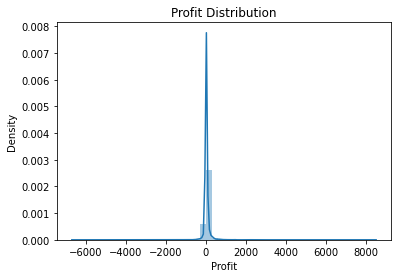

In [19]:
sns.distplot(df['Profit'])
plt.title("Profit Distribution");

__Your turn: Get the essential descriptive statistics for `Profit` using an appropriate function__

In [20]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

__Your turn: Do you notice anything interesting about the distribution?__

We have both positive and negative values in profits since it indicates either a profit or a loss based on the sales and original price of the items.

## Visualize Discount vs. Profit

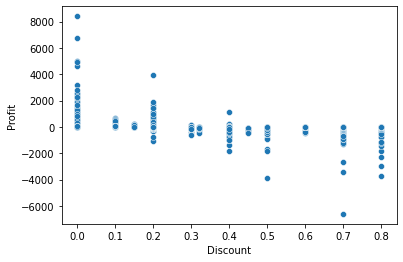

In [11]:
sns.scatterplot(x="Discount", y="Profit", data=df);

In the above visual, we look at a scatter plot showing the distribution of profits w.r.t discounts given

# 3. Univariate Anomaly Detection

Univariate is basically analysis done on a single attribute or feature. In this section, we will perform anomaly detection on a single attribute using the following methods.

- Statistical Process Control Methods (mean + 3sigma thresholding)
- Isolation Forest

We will start off by demonstrating both these techniques on the __`Sales`__ attribute and later on, you will implement similar techniques on the __`Profit`__ attribute.

## 3.1: Univariate Anomaly Detection on Sales using Statistical Modeling

Here we start off by implementing anomaly detecting using statistical modeling on the __`Sales`__ attribute

### Obtain Upper Limit Threshold for Sales

Here we are concerned about transactions with high sales values so we compute the upper limit using the $\mu$ + 3$\sigma$ rule where $\mu$ is the mean of the distribution and $\sigma$ is the standard deviation of the distribution.

In [21]:
mean_sales = df['Sales'].mean()
sigma_sales = df['Sales'].std()
three_sigma_sales = 3*sigma_sales

threshold_sales_value = mean_sales + three_sigma_sales
print('Threshold Sales:', threshold_sales_value)

Threshold Sales: 2099.5933023565394


### Visualize Outlier Region

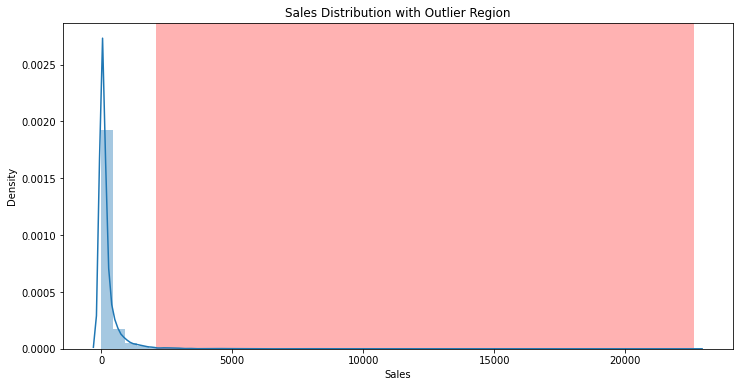

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.distplot(df['Sales'])
plt.axvspan(threshold_sales_value, df['Sales'].max(), facecolor='r', alpha=0.3)
plt.title("Sales Distribution with Outlier Region");

### Filter and Sort Outliers

Here we filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [14]:
sales_outliers_df = df['Sales'][df['Sales'] > threshold_sales_value]
print('Total Sales Outliers:', len(sales_outliers_df))
sales_outliers_sorted = sales_outliers_df.sort_values(ascending=False)
sales_outliers_sorted.head(5)

Total Sales Outliers: 127


2697    22638.480
6826    17499.950
8153    13999.960
2623    11199.968
4190    10499.970
Name: Sales, dtype: float64

### View Top 10 Outlier Transactions

In [15]:
(df.loc[sales_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).head(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
6826,Lafayette,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760
8153,Seattle,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808
2623,New York City,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888
4190,Newark,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856
9039,Detroit,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13,0.0,4946.3700
4098,Minneapolis,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5,0.0,4630.4755
4277,Lakewood,Technology,Machines,"3D Systems Cube Printer, 2nd Generation, Magenta",9099.930,7,0.0,2365.9818
8488,Arlington,Technology,Machines,HP Designjet T520 Inkjet Large Format Printer ...,8749.950,5,0.0,2799.9840
6425,Philadelphia,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,8399.976,4,0.4,1119.9968


### View Bottom 10 Outlier Transactions

In [16]:
(df.loc[sales_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
5300,Springfield,Furniture,Tables,Hon Rectangular Conference Tables,2275.500,10,0.0,386.8350
6101,New York City,Furniture,Chairs,Global Troy Executive Leather Low-Back Tilter,2254.410,5,0.1,375.7350
4881,Henderson,Technology,Accessories,Logitech diNovo Edge Keyboard,2249.910,9,0.0,517.4793
7487,Dover,Technology,Accessories,Logitech diNovo Edge Keyboard,2249.910,9,0.0,517.4793
1155,Harrisonburg,Furniture,Tables,"Chromcraft 48"" x 96"" Racetrack Double Pedestal...",2244.480,7,0.0,493.7856
8699,Nashville,Technology,Phones,Samsung Galaxy S III - 16GB - pebble blue (T-M...,2239.936,8,0.2,223.9936
9774,San Antonio,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
8424,Lakewood,Furniture,Bookcases,"Global Adaptabilites Bookcase, Cherry/Storm Gr...",2154.900,5,0.0,129.2940
6534,Buffalo,Office Supplies,Binders,GBC DocuBind TL300 Electric Binding System,2152.776,3,0.2,726.5619
8680,Richmond,Office Supplies,Appliances,Honeywell Enviracaire Portable HEPA Air Cleane...,2104.550,7,0.0,694.5015


## Q 3.2: Univariate Anomaly Detection on Profit using Statistical Modeling

In this section you will use the learning from Section 3.1 and implement anomaly detecting using statistical modeling on the __`Profit`__ attribute. Since we have both +ve (profits) and -ve (losses) values in the distribution, we will try to find anomalies for each.

### Obtain Upper Limit Threshold for Profit

__Your turn:__ Compute the upper and lower limits using the  𝜇  + 3 𝜎  rule where  𝜇  is the mean of the distribution and  𝜎  is the standard deviation of the distribution.

In [22]:
mean_profit = df['Profit'].mean()
sigma_profit = df['Profit'].std()
three_sigma_profit = 3*sigma_profit

threshold_profit_upper_limit = mean_profit + three_sigma_profit
threshold_profit_lower_limit = mean_profit - three_sigma_profit

print('Thresholds Profit:', threshold_profit_lower_limit, threshold_profit_upper_limit)

Thresholds Profit: -674.123426765088 731.4372193806576


### Visualize Outlier Regions

__Your turn:__ Visualize the upper and lower outlier regions in the distribution similar to what you did in 3.1

Text(0.5, 1.0, 'Profit Distribution with Outlier Regions')

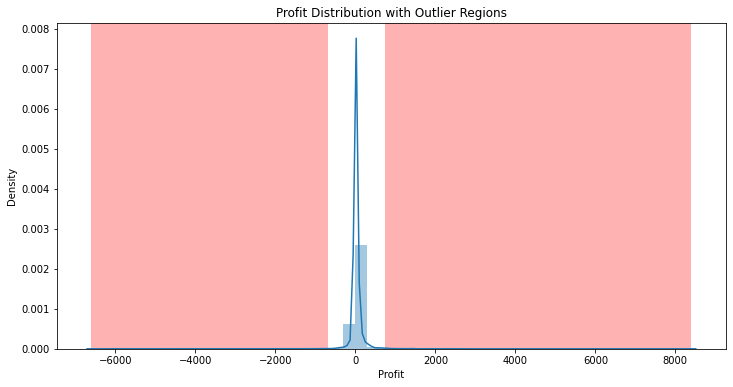

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.distplot(df['Profit'])
plt.axvspan(threshold_profit_upper_limit, df['Profit'].max(), facecolor='r', alpha=0.3)
plt.axvspan(df['Profit'].min(), threshold_profit_lower_limit, facecolor='r', alpha=0.3)
plt.title("Profit Distribution with Outlier Regions")

### Filter and Sort Outliers

__Your turn:__ Filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [26]:
profit_outliers_df = df['Profit'][(df['Profit'] > threshold_profit_upper_limit) | (df['Profit'] < threshold_profit_lower_limit)]
print('Total Profit Outliers:', len(profit_outliers_df))
profit_outliers_sorted = profit_outliers_df.sort_values(ascending=False)
profit_outliers_sorted.head(5)

Total Profit Outliers: 107


6826    8399.9760
8153    6719.9808
4190    5039.9856
9039    4946.3700
4098    4630.4755
Name: Profit, dtype: float64

### View Top 10 Outlier Transactions

__Your turn:__ View the top ten transactions based on highest profits

In [27]:
(df.loc[profit_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).head(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
6826,Lafayette,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760
8153,Seattle,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808
4190,Newark,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856
9039,Detroit,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13,0.0,4946.3700
4098,Minneapolis,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5,0.0,4630.4755
2623,New York City,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888
509,Atlanta,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,6354.950,5,0.0,3177.4750
8488,Arlington,Technology,Machines,HP Designjet T520 Inkjet Large Format Printer ...,8749.950,5,0.0,2799.9840
7666,Providence,Technology,Copiers,Hewlett Packard LaserJet 3310 Copier,5399.910,9,0.0,2591.9568
6520,Jackson,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,5443.960,4,0.0,2504.2216


### Q: Do you notice any interesting insights based on these transactions?

__A:__ Most of these are purchases for Copiers and Binders , looks like Canon products yielded some good profits`

### View Bottom 10 Outlier Transactions

__Your turn:__ View the bottom ten transactions based on lowest profits (highest losses)

In [29]:
(df.loc[profit_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
1199,Houston,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9639,Concord,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124
5310,Houston,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.7820
3151,Newark,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,2,0.7,-2639.9912
4991,Chicago,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
3011,Louisville,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800
9774,San Antonio,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
683,Burlington,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
7772,Lancaster,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780


### Q: Do you notice any interesting insights based on these transactions?

__A:__ Most of these are purchases for Machines and Binders , looks like Cibify 3D Printers yielded high losses

## 3.3: Univariate Anomaly Detection on Sales using Isolation Forest

You might have already learnt about this model from the curriculum. Just to briefly recap, the Isolation Forest model,  'isolates' observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Recursive partitioning can be represented by a tree structure. Hence, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

More details are available in this [User Guide](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)

### Initialize and Train Model

Here we initialize the isolation forest model with some hyperparameters assuming the proportion of outliers to be 1% of the total data (using the `contamination` setting)

In [28]:
from sklearn.ensemble import IsolationForest

sales_ifmodel = IsolationForest(n_estimators=100,
                                contamination=0.01)
sales_ifmodel.fit(df[['Sales']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

### Visualize Outlier Region

Here we visualize the outlier region in the data distribution

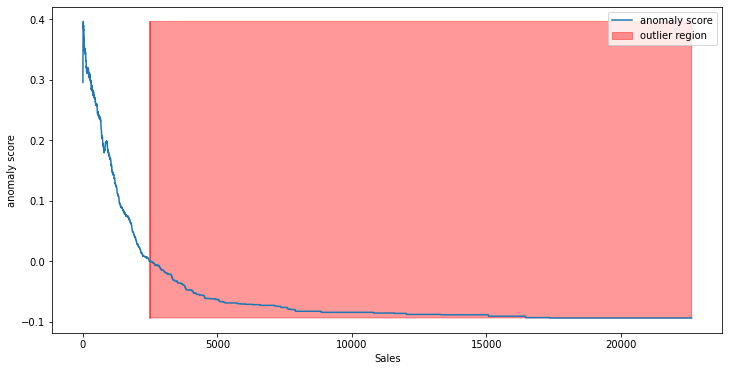

In [30]:
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = sales_ifmodel.decision_function(xx)
outlier = sales_ifmodel.predict(xx)
plt.figure(figsize=(12, 6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales');

### Filter and Sort Outliers

Here we predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [32]:
outlier_predictions = sales_ifmodel.predict(df[['Sales']])

sales_outliers_df = df[['Sales']]
sales_outliers_df['Outlier'] = outlier_predictions
sales_outliers_df = sales_outliers_df[sales_outliers_df['Outlier'] == -1]['Sales']

print('Total Sales Outliers:', len(sales_outliers_df))
sales_outliers_sorted = sales_outliers_df.sort_values(ascending=False)
sales_outliers_sorted.head(5)

Total Sales Outliers: 101


2697    22638.480
6826    17499.950
8153    13999.960
2623    11199.968
4190    10499.970
Name: Sales, dtype: float64

### View Top 10 Outlier Transactions

In [33]:
(df.loc[sales_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).head(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
6826,Lafayette,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760
8153,Seattle,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808
2623,New York City,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888
4190,Newark,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856
9039,Detroit,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13,0.0,4946.3700
4098,Minneapolis,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5,0.0,4630.4755
4277,Lakewood,Technology,Machines,"3D Systems Cube Printer, 2nd Generation, Magenta",9099.930,7,0.0,2365.9818
8488,Arlington,Technology,Machines,HP Designjet T520 Inkjet Large Format Printer ...,8749.950,5,0.0,2799.9840
6425,Philadelphia,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,8399.976,4,0.4,1119.9968


### View Bottom 10 Outlier Transactions

In [34]:
(df.loc[sales_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7474,Henderson,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2573.820,9,0.0,746.4078
6884,Minneapolis,Furniture,Chairs,Hon Pagoda Stacking Chairs,2567.840,8,0.0,770.3520
8271,New York City,Furniture,Chairs,Hon 4700 Series Mobuis Mid-Back Task Chairs wi...,2563.056,8,0.1,313.2624
3011,Louisville,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800
6010,Los Angeles,Technology,Machines,Zebra GX420t Direct Thermal/Thermal Transfer P...,2548.560,6,0.2,286.7130
7280,Columbia,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,2541.980,2,0.0,1270.9900
263,Houston,Technology,Machines,Xerox WorkCentre 6505DN Laser Multifunction Pr...,2519.958,7,0.4,-251.9958
7937,Brentwood,Office Supplies,Appliances,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,2518.290,9,0.0,654.7554
3443,New York City,Office Supplies,Appliances,Hoover Shoulder Vac Commercial Portable Vacuum,2504.740,7,0.0,626.1850
5530,Omaha,Technology,Phones,ClearOne CHATAttach 160 - speaker phone,2479.960,4,0.0,743.9880


## Q 3.4: Univariate Anomaly Detection on Profit using Isolation Forest

In this section you will use the learning from Section 3.3 and implement anomaly detecting using isolation on the __`Profit`__ attribute. Since we have both +ve (profits) and -ve (losses) values in the distribution, we will try to find anomalies for each.

### Initialize and Train Model

__Your Turn:__ Initialize the isolation forest model with similar hyperparameters as Section 3.3 and also assuming the proportion of outliers to be 1% of the total data (using the contamination setting)

In [35]:
profit_ifmodel = IsolationForest(n_estimators=100,
                                contamination=0.01)
profit_ifmodel.fit(df[['Profit']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

### Visualize Outlier Regions

__Your turn:__ Visualize the upper and lower outlier regions in the distribution similar to what you did in 3.3

Text(0.5, 0, 'Profit')

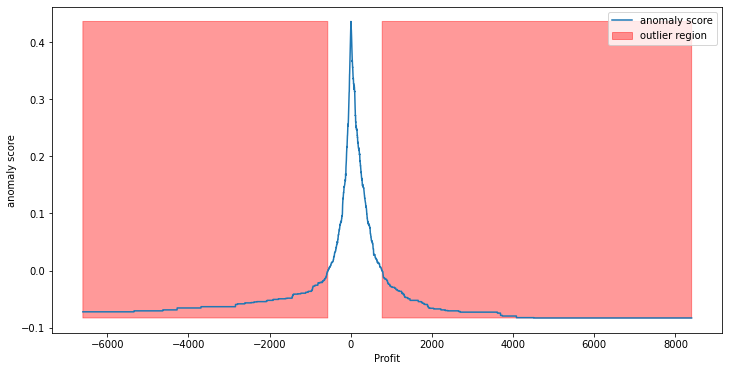

In [36]:
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = profit_ifmodel.decision_function(xx)
outlier = profit_ifmodel.predict(xx)
plt.figure(figsize=(12, 6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')

### Filter and Sort Outliers

__Your Turn:__ Predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values similar to 3.3

In [37]:
outlier_predictions = profit_ifmodel.predict(df[['Profit']])

profit_outliers_df = df[['Profit']]
profit_outliers_df['Outlier'] = outlier_predictions
profit_outliers_df = profit_outliers_df[profit_outliers_df['Outlier'] == -1]['Profit']

print('Total Profit Outliers:', len(profit_outliers_df))
profit_outliers_sorted = profit_outliers_df.sort_values(ascending=False)
profit_outliers_sorted.head(5)

Total Profit Outliers: 99


6826    8399.9760
8153    6719.9808
4190    5039.9856
9039    4946.3700
4098    4630.4755
Name: Profit, dtype: float64

### View Top 10 Outlier Transactions

__Your turn:__ View the top ten transactions based on highest profits

In [39]:
(df.loc[profit_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).head(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
6826,Lafayette,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760
8153,Seattle,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808
4190,Newark,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856
9039,Detroit,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13,0.0,4946.3700
4098,Minneapolis,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5,0.0,4630.4755
2623,New York City,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888
509,Atlanta,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,6354.950,5,0.0,3177.4750
8488,Arlington,Technology,Machines,HP Designjet T520 Inkjet Large Format Printer ...,8749.950,5,0.0,2799.9840
7666,Providence,Technology,Copiers,Hewlett Packard LaserJet 3310 Copier,5399.910,9,0.0,2591.9568
6520,Jackson,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,5443.960,4,0.0,2504.2216


### View Bottom 10 Outlier Transactions

__Your turn:__ View the bottom ten transactions based on lowest profits (highest losses)

In [38]:
(df.loc[profit_outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
1199,Houston,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9639,Concord,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124
5310,Houston,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.7820
3151,Newark,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,2,0.7,-2639.9912
4991,Chicago,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
3011,Louisville,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800
9774,San Antonio,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
683,Burlington,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
7772,Lancaster,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780


### Q: Do you observe any similarity in the results with the previous method?

__A:__ Yes

Another interesting approach to check out would be the [Generalized ESD Test for Outliers](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm)



# 4. Multivariate Anomaly Detection

Multivariate is basically analysis done on more than one attribute or feature at a time. In this section, we will perform anomaly detection on two attributes (__`Discount`__ & __`Profit`__) using the following methods.

- Clustering Based Local Outlier Factor (CBLOF)
- Isolation Forest
- Auto-Encoders

You will learn how to train these models to detect outliers and also visualize these outliers. For this section we will be using the __[`pyod`](https://pyod.readthedocs.io/en/latest/)__ package so make sure you have it installed.

In [40]:
!pip install pyod

     |████████████████████████████████| 105 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-0.9.0-py3-none-any.whl size=122560 sha256=83816ab257f70d60ef023b4592d09cf7b689922eac07b6b40fd3fccba183078f
  Stored in directory: /root/.cache/pip/wheels/42/5f/59/5984a6116a4d19aee28d8ebeffd431364ce1cf21eb73a6ad34
Successfully built pyod


## Extract Subset Data for Outlier Detection

In [41]:
cols = ['Discount', 'Profit']
subset_df = df[cols]
subset_df.head()

,Discount,Profit
0,0.00,41.9136
1,0.00,219.5820
2,0.00,6.8714
3,0.45,-383.0310
4,0.20,2.5164


## Feature Scaling

In [42]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0, 1))
subset_df[cols] = mms.fit_transform(subset_df)
subset_df.head()

,Discount,Profit
0,0.0000,0.442794
1,0.0000,0.454639
2,0.0000,0.440458
3,0.5625,0.414464
4,0.2500,0.440168


## 4.1: Multivariate Anomaly Detection with Clustering Based Local Outlier Factor (CBLOF)

The CBLOF model takes as an input the dataset and the cluster model that was generated by a clustering algorithm. It classifies the clusters into small clusters and large clusters using the parameters alpha and beta. The anomaly score is then calculated based on the size of the cluster the point belongs to as well as the distance to the nearest large cluster.

By default, kMeans is used for clustering algorithm. You can read more in the [official documentation](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof)

### Initialize and Train Model

Here we initialize the CBLOF model with some hyperparameters assuming the proportion of outliers to be 1% of the total data (using the `contamination` setting)

In [43]:
from pyod.models import cblof

cblof_model = cblof.CBLOF(contamination=0.01, random_state=42)
cblof_model.fit(subset_df)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False)

### Filter and Sort Outliers

Here we predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values

In [44]:
outlier_predictions = cblof_model.predict(subset_df)

outliers_df = subset_df.copy(deep=True)
outliers_df['Outlier'] = outlier_predictions
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted = outliers_df.sort_values(by=['Profit', 'Discount'], ascending=False)
outliers_sorted.head(5)

Total Outliers: 100


,Discount,Profit,Outlier
6826,0.0,1.000000,1
8153,0.0,0.888000,1
4190,0.0,0.776000,1
9039,0.0,0.769759,1
4098,0.0,0.748699,1


### View Bottom 10 Outlier Transactions

In [45]:
(df.loc[outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
463,Phoenix,Furniture,Tables,Bush Advantage Collection Racetrack Conference...,1272.630,6,0.5,-814.4832
4128,Charlotte,Technology,Machines,HP Designjet T520 Inkjet Large Format Printer ...,2624.985,3,0.5,-944.9946
8993,Columbia,Furniture,Tables,Balt Solid Wood Round Tables,1875.258,7,0.4,-968.8833
5320,Knoxville,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,2314.116,7,0.4,-1002.7836
165,San Antonio,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.4,-1359.9920
27,Philadelphia,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.430,7,0.5,-1665.0522
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
9639,Concord,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124
683,Burlington,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
7772,Lancaster,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780


We can definitely see some huge losses incurred based on giving higher discounts even if the sales amount was high which is interesting as well as concerning.

## Q 4.2: Multivariate Anomaly Detection with Isolation Forest

Here you will detect anomalies using the Isolation Forest model and use the learnings from 4.1. Here you will use the [`pyod`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest) version of [Isolation Forest](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest) which is basically a wrapper over the `scikit-learn` version but with more functionalities.

### Initialize and Train Model

__Your Turn:__ Initialize the isolation forest model with similar hyperparameters as before and also assuming the proportion of outliers to be 1% of the total data (using the contamination setting)

In [46]:
from pyod.models import iforest

if_model = iforest.IForest(n_estimators=100,
                                contamination=0.01)
if_model.fit(subset_df)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

### Filter and Sort Outliers

__Your Turn:__ Predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values similar to 4.1

In [47]:

outlier_predictions = if_model.predict(subset_df)

outliers_df = subset_df.copy(deep=True)
outliers_df['Outlier'] = outlier_predictions
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted = outliers_df.sort_values(by=['Profit', 'Discount'], ascending=False)
outliers_sorted.head(5)

Total Outliers: 100


,Discount,Profit,Outlier
6826,0.0,1.000000,1
8153,0.0,0.888000,1
4190,0.0,0.776000,1
9039,0.0,0.769759,1
4098,0.0,0.748699,1


### View Bottom 10 Outlier Transactions

__Your turn:__ View the bottom ten transactions 

In [48]:
(df.loc[outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
1199,Houston,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9639,Concord,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124
5310,Houston,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.7820
3151,Newark,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,2,0.7,-2639.9912
4991,Chicago,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
3011,Louisville,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800
9774,San Antonio,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
683,Burlington,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
7772,Lancaster,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780


### Q: Do you notice any differences in the results with the previous model?

We do notice some transactions with 80% discount and high losses

## Q 4.3: Multivariate Anomaly Detection with Auto-encoders

Here you will detect anomalies using the Auto-encoder model and use the learnings from 4.1. Here you will use the [Auto-encoder](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.auto_encoder) model from `pyod` which is a deep learning model often used for learning useful data representations in an unsupervised fashion without any labeled data. 

![](outlier_ae.png)

Similar to PCA, AE could be used to detect outlier objects in the data by calculating the reconstruction errors

### Initialize Model

Here we initiaze an auto-encoder network with a few hidden layers so that we could train it for a 100 epochs

In [49]:
from pyod.models import auto_encoder

ae_model = auto_encoder.AutoEncoder(hidden_neurons=[2, 32, 32, 2], 
                                    hidden_activation='relu',
                                    output_activation='sigmoid',
                                    epochs=100,
                                    batch_size=32,
                                    contamination=0.01)

### Train Model

__Your turn:__ Train the model by calling the `fit()` function on the right data

In [50]:
ae_model.fit(subset_df)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                9

AutoEncoder(batch_size=32, contamination=0.01, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[2, 32, 32, 2],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fedb37fa170>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

### Filter and Sort Outliers

__Your Turn:__ Predict outliers in our dataset using our trained model and filter out the outlier observations and sort by descending order and view the top 5 outlier values similar to 4.1

In [51]:
outlier_predictions = ae_model.predict(subset_df)

outliers_df = subset_df.copy(deep=True)
outliers_df['Outlier'] = outlier_predictions
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted = outliers_df.sort_values(by=['Profit', 'Discount'], ascending=False)
outliers_sorted.head(5)

Total Outliers: 100


,Discount,Profit,Outlier
6826,0.0,1.000000,1
8153,0.0,0.888000,1
4190,0.0,0.776000,1
9039,0.0,0.769759,1
4098,0.0,0.748699,1


### View Bottom 10 Outlier Transactions

__Your turn:__ View the bottom ten transactions 

In [52]:
(df.loc[outliers_sorted.index.tolist()][['City', 'Category', 'Sub-Category', 'Product Name', 
                                              'Sales', 'Quantity', 'Discount', 'Profit']]).tail(10)

,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,Jacksonville,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
1199,Houston,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9639,Concord,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124
5310,Houston,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.7820
3151,Newark,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,2,0.7,-2639.9912
4991,Chicago,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
3011,Louisville,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800
9774,San Antonio,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
683,Burlington,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
7772,Lancaster,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.9780


## 4.4: Visualize Anomalies and Compare Anomaly Detection Models

Here we will look at the visual plots of anomalies as detected by the above three models

In [53]:
def visualize_anomalies(model, xx, yy, data_df, ax_obj, subplot_title):
    
    # predict raw anomaly score
    scores_pred = model.decision_function(data_df) * -1
    # prediction of a datapoint category outlier or inlier
    y_pred = model.predict(data_df)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)


    out_df = data_df.copy(deep=True)
    out_df['Outlier'] = y_pred.tolist()
    # discount - inlier feature 1,  profit - inlier feature 2
    inliers_discount = out_df[out_df['Outlier'] == 0]['Discount'].values
    inliers_profit = out_df[out_df['Outlier'] == 0]['Profit'].values
    # discount - outlier feature 1, profit - outlier feature 2
    outliers_discount = out_df[out_df['Outlier'] == 1]['Discount'].values
    outliers_profit = out_df[out_df['Outlier'] == 1]['Profit'].values

    # Use threshold value to consider a datapoint inlier or outlier
    # threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    threshold = np.percentile(scores_pred, 100 * outliers_fraction)   
    # decision function calculates the raw anomaly score for every point
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    # fill blue map colormap from minimum anomaly score to threshold value
    ax_obj.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    # draw red contour line where anomaly score is equal to thresold
    a = ax_obj.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    ax_obj.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    b = ax_obj.scatter(inliers_discount, inliers_profit, c='white',s=20, edgecolor='k')
    c = ax_obj.scatter(outliers_discount, outliers_profit, c='black',s=20, edgecolor='k')


    ax_obj.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
               prop=matplotlib.font_manager.FontProperties(size=10),loc='upper right')

    ax_obj.set_xlim((0, 1))
    ax_obj.set_ylim((0, 1))
    ax_obj.set_xlabel('Discount')
    ax_obj.set_ylabel('Sales')
    ax_obj.set_title(subplot_title)

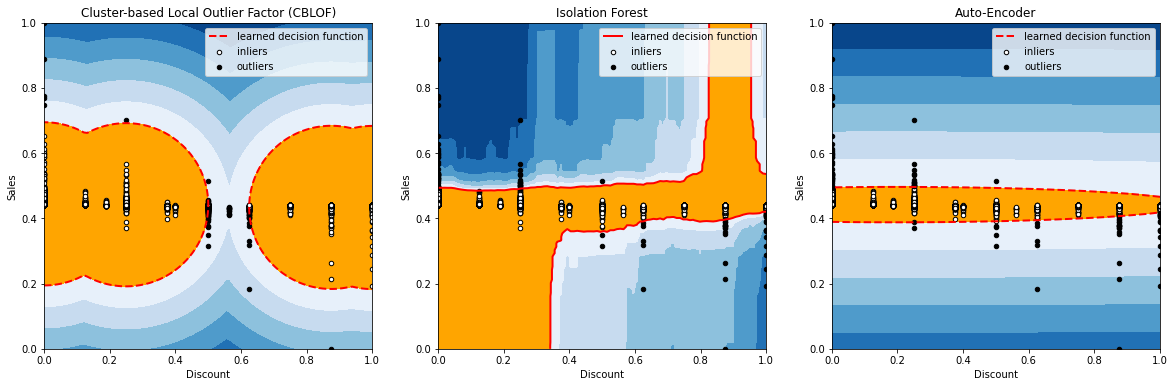

In [54]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax_objs = [ax[0], ax[1], ax[2]]
models = [cblof_model, if_model, ae_model]
plot_titles = ['Cluster-based Local Outlier Factor (CBLOF)',
               'Isolation Forest',
               'Auto-Encoder']

for ax_obj, model, plot_title in zip(ax_objs, models, plot_titles):
    visualize_anomalies(model=model,
                        xx=xx, yy=yy,
                        data_df=subset_df,
                        ax_obj=ax_obj,
                        subplot_title=plot_title)
plt.axis('tight');
